In [1]:
import numpy as np
import pandas as pd
import requests, warnings

In [2]:
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from kpler.sdk.configuration import Configuration
from kpler.sdk import Platform
config = Configuration(Platform.Liquids, "syed.ahmad@petrochinaintl.co.uk", "petroineos")
from kpler.sdk import FlowsDirection, FlowsSplit, FlowsPeriod, FlowsMeasurementUnit

# % matplotlib inline

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
# trades endpoint
from kpler.sdk.resources.trades import Trades
trades_client = Trades(config)

In [3]:
# flows endpoint
from kpler.sdk.resources.flows import Flows
from kpler.sdk import FlowsDirection, FlowsSplit, FlowsPeriod, FlowsMeasurementUnit
flows_client = Flows(config)

In [ ]:
# trades_client.get_columns().to_csv('kpler_trades_columns.csv')

In [7]:
short_cols = [
    'trade_id',
    'shipment_id',
    'status',
    'vessel_imo',
    "vessel_name",
    'vessel_name_2',
    'vessel_name_3',
    'closest_ancestor_group',
    "closest_ancestor_product",
    "closest_ancestor_grade",
    'closest_ancestor_grade_api',
    'closest_ancestor_grade_sulfur',
    'cargo_origin_barrels_split_by_product',
    "start",
    "end",
    "origin_location_name",
    'installation_origin_name',
    'origin_country_name',
    'zone_origin_name',
    'origin_subcontinent_name',
    'continent_origin_name',
    'next_forecasted_origin_location_name',
    'next_forecasted_origin_eta',
    'initial_seller_name',
    'charterer_name',
    "destination_location_name",
    'next_forecasted_destination_location_name',
    'next_forecasted_destination_location_eta',
    'installation_destination_name',
    'destination_country_name',
    'zone_destination_name',
    'destination_subcontinent_name',
    'continent_destination_name',
    'final_buyer_name',
    'origin_eta_source',
    'destination_eta_source',
    'cargo_sources'
]

### ----- flows ------

In [4]:
oecd_europe = ['Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands']

In [5]:
today = datetime.date.today()

In [6]:
def clean_ts(df):
    df.drop(columns='Period End Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [7]:
def get_flows(origin=[], destination=[], direction='Import'):
    
    if direction == 'Import':
        flow = [FlowsDirection.Import]
        layer = [FlowsSplit.OriginTradingRegions]
    else:
        flow = [FlowsDirection.Export]
        layer = [FlowsSplit.DestinationTradingRegions]
    
    df = flows_client.get(
    with_intra_country=False,
    from_zones=origin,
    to_zones=destination,
    products=['Crude/Condensate'],
    flow_direction=flow,
    split=layer,
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
#     end_date=today,
    )
    return df

In [8]:
def get_single_flow(origin=[], destination=[], direction='Import'):
    
    if direction == 'Import':
        flow = [FlowsDirection.Import]
    else:
        flow = [FlowsDirection.Export]
    
    df = flows_client.get(
    with_intra_country=False,
    from_zones=origin,
    to_zones=destination,
    products=['Crude/Condensate'],
    flow_direction=flow,
    split=[FlowsSplit.Total],
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
#     end_date=today,
    )
    return df

In [16]:
exports = clean_ts(get_single_flow(origin=oecd_europe, destination=['americas', 'africa', 'asia'], direction='Export'))
# imports = get_flows(destination=oecd_europe, direction='Import')

In [267]:
exports.set_index('Date', inplace=True)

In [9]:
test_df = get_flows(destination=oecd_europe, direction='Import')

NameError: name 'date' is not defined

### -------- oil in transit -------------

In [ ]:
from kpler.sdk.resources.fleet_metrics import FleetMetrics
from kpler.sdk import FleetMetricsAlgo, FleetMetricsSplit, FleetMetricsPeriod
fleet_metrics_client = FleetMetrics(config)
df = fleet_metrics_client.get(
    metric=FleetMetricsAlgo.LoadedVessels,
#     zones=["China"],
    period=FleetMetricsPeriod.Daily,
    split=FleetMetricsSplit.Total,
    start_date=dt(2021,1,1),
    products='Crude'
)

In [ ]:
# df.to_csv('kpler.csv')

In [ ]:
df.plot(kind='line', x='Date', y='Total', figsize=(20,10))

# flows from API

In [34]:
oecd_imports = clean_ts(flows_client.get(
    from_zones=["13,6807,110608,235,241,243,112932,337,343,6734,517,537,110654,561,605,751,757,110691,941,151,61,7,23,675"],
    to_zones=["3790"],
    flow_direction = [FlowsDirection.Import],
    with_intra_country=False,
    split = [FlowsSplit.Total],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
    granularity=[FlowsPeriod.Monthly]
    
)).set_index('Date')

In [33]:
df

Date    Total
0   2013-01-01  6061.69
1   2013-02-01  6628.85
2   2013-03-01  6985.94
3   2013-04-01  7073.49
4   2013-05-01  6955.74
..         ...      ...
111 2022-04-01  7354.93
112 2022-05-01  7975.26
113 2022-06-01  5720.25
114 2022-07-01  1110.70
115 2022-08-01   560.56

[116 rows x 2 columns]

# flows from DB

In [3]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [4]:
# def convert_to_datime(df):
#     df['voyage_start'] = pd.to_datetime(df['voyage_start'])
#     df['voyage_end'] = pd.to_datetime(df['voyage_end'])
#     return df

In [5]:
# def aggregate_to_monthly(df, col):
#     df['month'] = df[col].dt.date
#     df.set_index('date', inplace=True)
#     df_grouped = df.groupby(['date']).resample('MS').sum(['cargo_origin_barrels_split_by_product'])
#     return df_grouped

In [6]:
oecd_europe = ('Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands')

In [6]:
oecd_exports_query = f'''select voyage_start date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
where origin_country_name in {oecd_europe} and destination_country_name not in {oecd_europe}
group by voyage_start
order by voyage_start desc
'''

In [7]:
oecd_imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
where origin_country_name not in {oecd_europe} and destination_country_name in {oecd_europe}
group by voyage_end
order by voyage_end desc
'''

In [8]:
def aggregate_daily_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('D').sum().astype(float)
    return df_grouped

In [9]:
def aggregate_monthly_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped['volume'] = df_grouped['volume']/(df_grouped.index.daysinmonth*1000)
    return df_grouped['volume']

In [265]:
oecd_exports_ts = aggregate_monthly_kbd(ag_get_data(oecd_exports_query))

In [10]:
oecd_import_ts = aggregate_monthly_kbd(ag_get_data(oecd_imports_query))

In [13]:
oecd_import_ts.tail(10)

date
2021-12-01    6967.716355
2022-01-01    6650.017290
2022-02-01    7629.742393
2022-03-01    6848.934226
2022-04-01    7210.605300
2022-05-01    7806.409871
2022-06-01    5747.466200
2022-07-01    1075.745839
2022-08-01     529.470323
2022-09-01     100.582833
Freq: MS, Name: volume, dtype: float64

In [37]:
comparison = oecd_imports.merge(oecd_import_ts, left_index=True, right_index=True)

In [38]:
comparison['delta'] = comparison['volume'] - comparison['Total']

In [40]:
comparison['delta'].plot(kind='bar', figsize=(20,10))

<AxesSubplot:>

In [272]:
comparison.to_csv('check.csv')

## flows vs trades comparison 

In [152]:
def aggregate_monthly_kbd_trades(df):
#     df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped = df_grouped/(df_grouped.index.daysinmonth*1000)
    return df_grouped

In [153]:
def comparison(origin):
    ts = clean_ts(flows_client.get(
    from_zones=origin,
    to_zones=["3790"],
    flow_direction = [FlowsDirection.Import],
    with_intra_country=False,
    split = [FlowsSplit.Total],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
    granularity=[FlowsPeriod.Monthly]
    ))
    
    trades_raw = trades_client.get(
    from_zones=origin,
    to_zones=["3790"],
    with_intra_country=False,
    start_date=date(2013,1,1),
    columns=short_cols
    )
    
    trades = aggregate_monthly_kbd_trades(trades_raw.groupby('end')['cargo_origin_barrels_split_by_product'].sum()).reset_index()
    trades.columns = ['Date', 'trades_kbd']
    
    comparison = ts.merge(trades, on='Date')
    comparison['delta'] = comparison['Total'] - comparison['trades_kbd']
#     comparison['delta'].plot(kind='bar', figsize=(20,10))
    
    return comparison

In [150]:
comparison_list = ['United States', 'West Africa', 'Middle east', 'Ceyhan', 'South America', 'Russian Federation', 'Libya', 'Algeria']

In [151]:
delta_list=[]
for c in comparison_list:
    delta = comparison(c)
    delta['origin']=c
    delta_list.append(delta)
deltas_df = pd.concat(delta_list)

In [85]:
deltas_pivot = deltas_df.pivot(columns='origin', values='delta', index='Date')

array([<AxesSubplot:title={'center':'Ceyhan'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'Middle east'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'South America'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'United States'}, xlabel='Date'>,
       <AxesSubplot:title={'center':'West Africa'}, xlabel='Date'>],
      dtype=object)

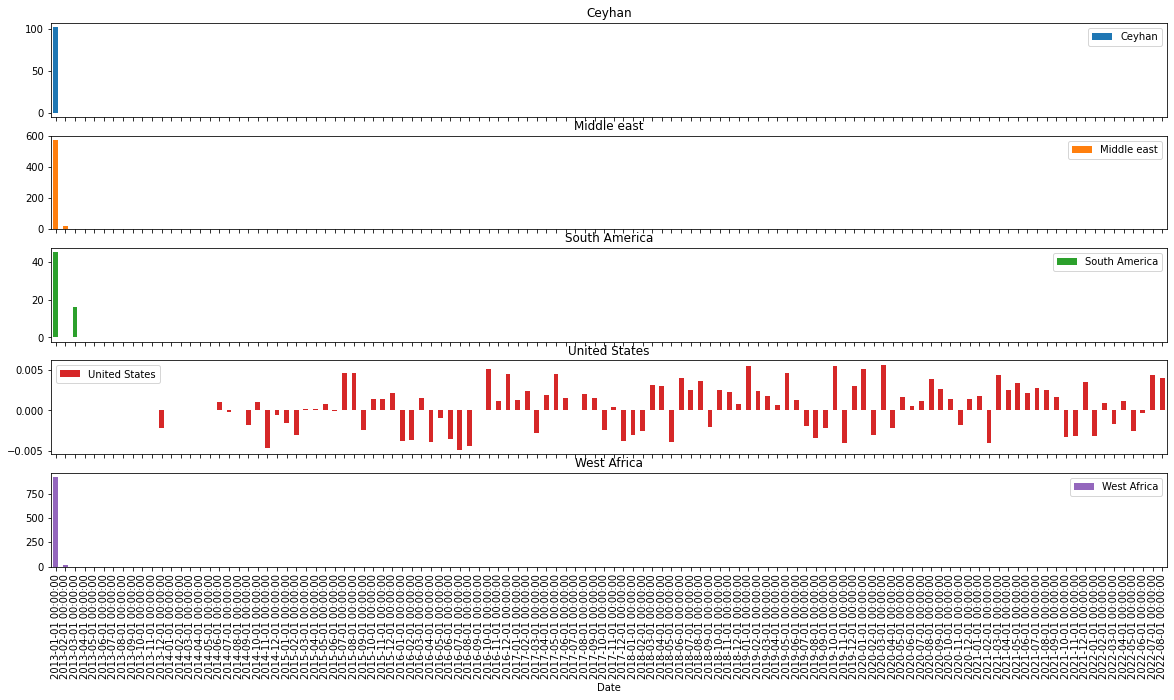

In [89]:
deltas_pivot.plot(kind='bar', subplots=True, figsize=(20,10))

## flows vs DB comparison 

In [105]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [106]:
oecd_europe = ('Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands')

In [114]:
def aggregate_monthly_kbd_db(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped['volume'] = df_grouped['volume']/(df_grouped.index.daysinmonth*1000)
    return df_grouped

In [197]:
def aggregate_daily_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('D').sum().astype(float)
    return df_grouped['volume']

In [198]:
def db_country_imports(origin):
    country_imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
    where origin_country_name = '{origin}' and destination_country_name in {oecd_europe}
    group by voyage_end
    order by voyage_end desc
    '''
    
    ts = aggregate_daily_kbd(ag_get_data(country_imports_query))
    return ts

In [199]:
test = db_country_imports('Nigeria')

In [200]:
test

date
2013-01-13    1052461.0
2013-01-14          0.0
2013-01-15          0.0
2013-01-16          0.0
2013-01-17     515424.0
                ...    
2022-06-29     611275.0
2022-06-30          0.0
2022-07-01          0.0
2022-07-02          0.0
2022-07-03    1040686.0
Freq: D, Name: volume, Length: 3459, dtype: float64

In [159]:
def db_subcont_imports(origin):
    imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
    where origin_subcontinent_name = '{origin}' and destination_country_name in {oecd_europe}
    group by voyage_end
    order by voyage_end desc
    '''
    
    ts = aggregate_monthly_kbd_db(ag_get_data(imports_query))
    return ts

In [163]:
def comparison_db(layer, origin):
    
    ts = clean_ts(flows_client.get(
    from_zones=origin,
    to_zones=["3790"],
    flow_direction = [FlowsDirection.Import],
    with_intra_country=False,
    split = [FlowsSplit.Total],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
    granularity=[FlowsPeriod.Monthly]
    )).set_index('Date')
    
    if layer == 'country':
        db = db_country_imports(origin)
    else:
        db = db_subcont_imports(origin)
    
    comparison= ts.merge(db, left_index=True, right_index=True)
    comparison['delta'] = comparison['volume'] - comparison['Total']
    return comparison

In [164]:
def plot_diffs(layer, c_list):
    delta_list=[]
    for c in c_list:
        delta = comparison_db(layer, c)
        delta['origin']=c
        delta_list.append(delta)
    deltas_df = pd.concat(delta_list)
    deltas_pivot = deltas_df.pivot(columns='origin', values='delta')
    deltas_pivot.plot(kind='bar', subplots=True, figsize=(15,15))
    return deltas_pivot

In [209]:
country_list = ['United States','Nigeria', 'Brazil', 'Russian Federation', 'Libya', 'Algeria', 'Saudi Arabia', 'Iraq', 'Kuwait']
region_list = ['Western Africa', 'South America', 'Northern America', 'Northern Africa', 'Middle East']

In [214]:
def clean_names(str_list):
    new_list=[]
    for i in range(len(str_list)):
        new_list.append(str_list[i].lower())
        new_list[i] = new_list[i].replace(' ','_')
    return new_list

In [215]:
n = clean_names(country_list)

In [217]:
country_list

['United States',
 'Nigeria',
 'Brazil',
 'Russian Federation',
 'Libya',
 'Algeria',
 'Saudi Arabia',
 'Iraq',
 'Kuwait']

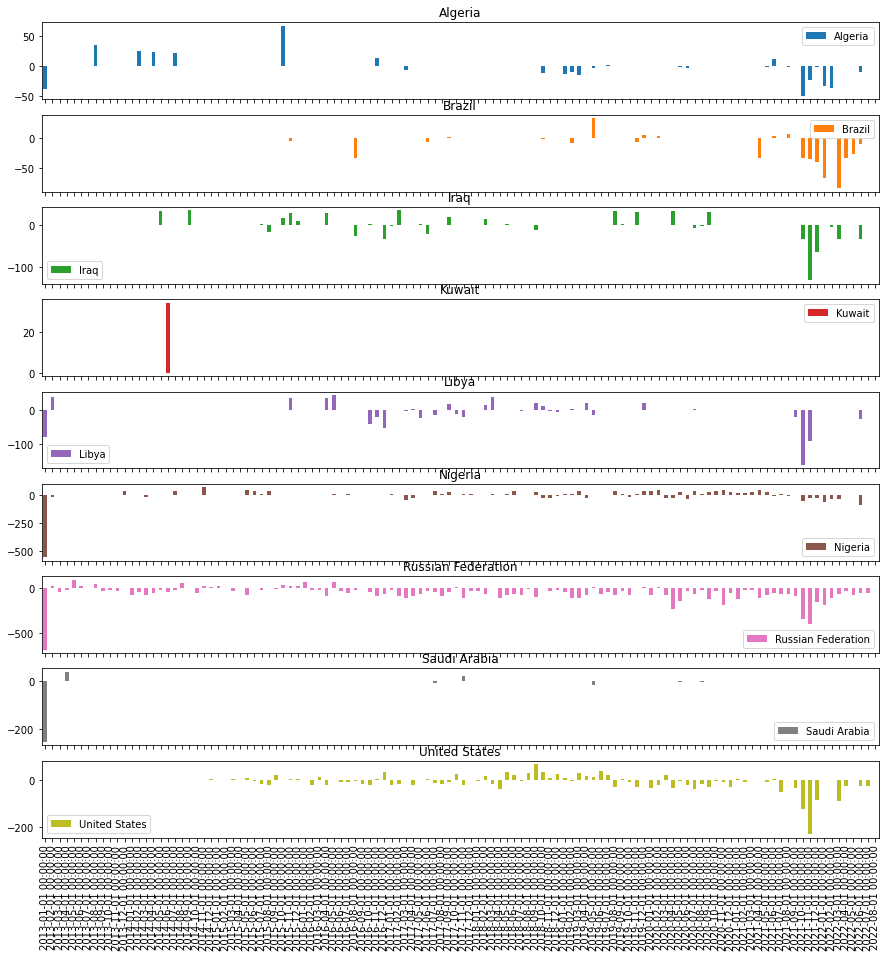

In [165]:
db_diffs = plot_diffs('country', country_list)

In [156]:
db_diffs['2014':].plot(kind='bar', subplots=True, figsize=(15,15))

array([<AxesSubplot:title={'center':'Algeria'}>,
       <AxesSubplot:title={'center':'Brazil'}>,
       <AxesSubplot:title={'center':'Libya'}>,
       <AxesSubplot:title={'center':'Nigeria'}>,
       <AxesSubplot:title={'center':'Russian Federation'}>,
       <AxesSubplot:title={'center':'United States'}>], dtype=object)

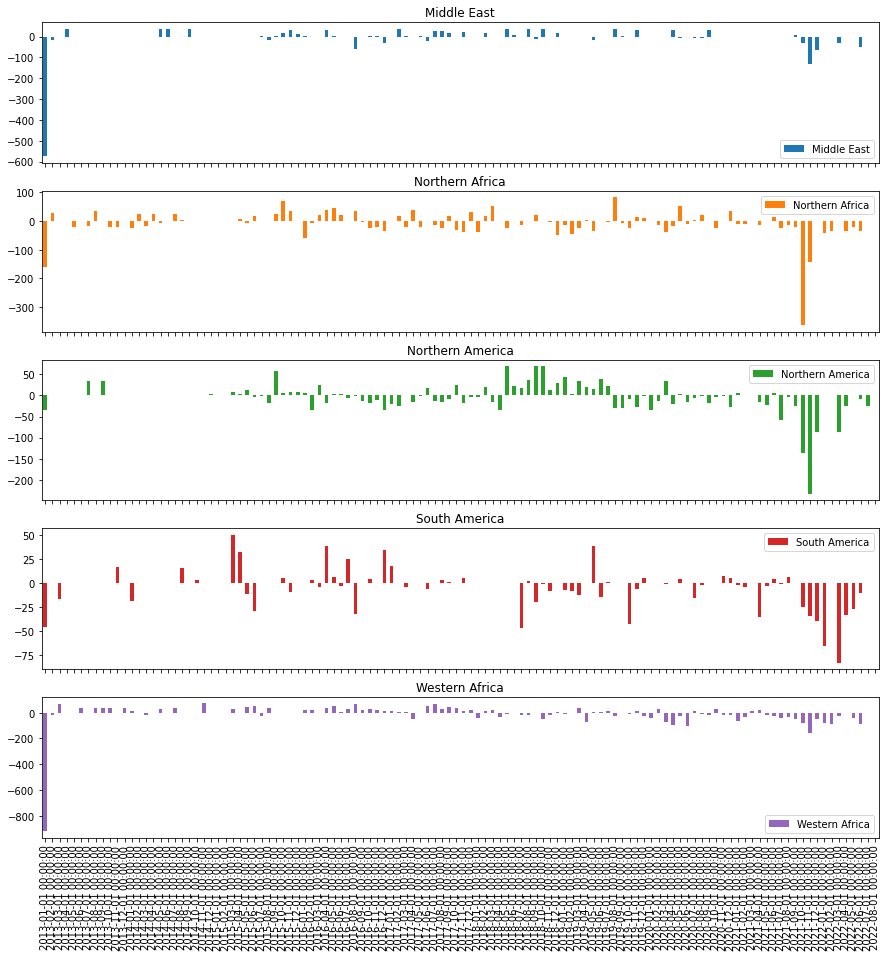

In [172]:
db_diffs_subcont = plot_diffs('subcont', region_list)

array([<AxesSubplot:title={'center':'Middle East'}>,
       <AxesSubplot:title={'center':'Northern Africa'}>,
       <AxesSubplot:title={'center':'Northern America'}>,
       <AxesSubplot:title={'center':'South America'}>,
       <AxesSubplot:title={'center':'Western Africa'}>], dtype=object)

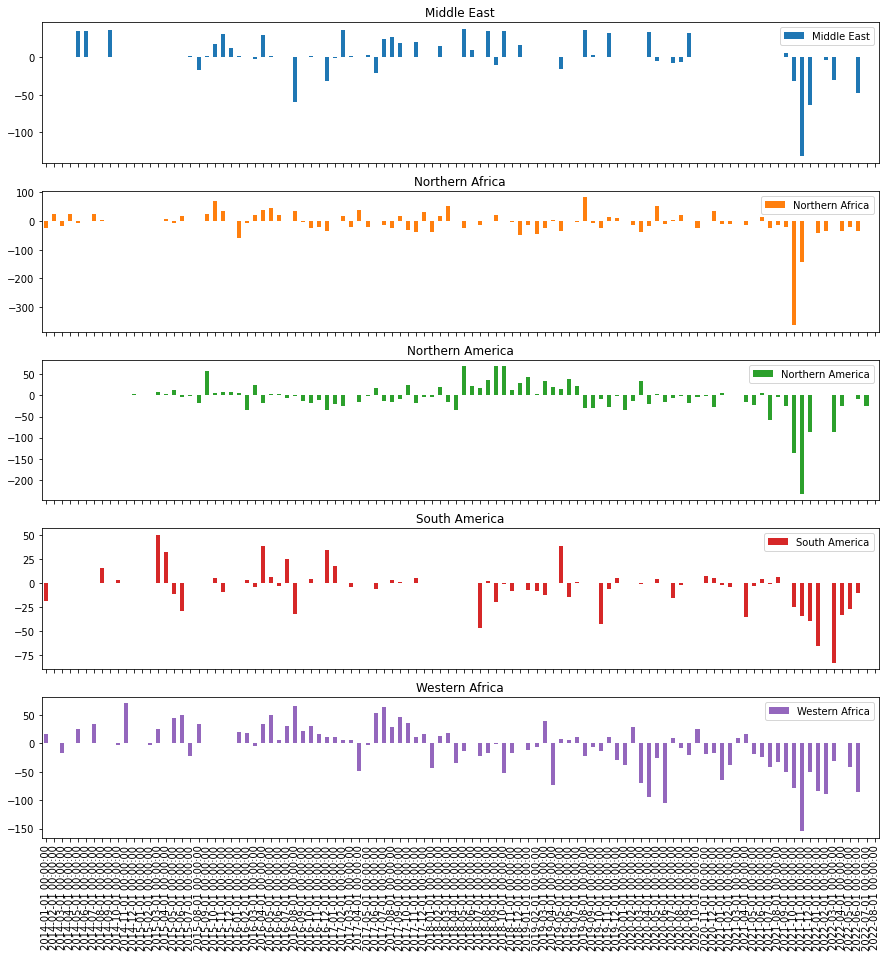

In [173]:
db_diffs_subcont['2014':].plot(kind='bar', subplots=True, figsize=(15,15))

In [ ]:
test = ag_get_data()

## CPC regressions / flow regressions

In [1]:
% matplotlib inline

UsageError: Line magic function `%` not found.


In [5]:
from tshistory.api import timeseries
import statsmodels.api as sm

In [6]:
# testing with args
def get_flow(prod=['Crude/Condensate'], dest='3790', origin=[]):
    df = flows_client.get(
    with_intra_country=False,
    products=prod,
    to_zones=dest,
    from_zones=origin,
    flow_direction=[FlowsDirection.Import],
    split=[FlowsSplit.Total],
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
#     end_date=today,
    )
    df.drop(columns='Period End Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [94]:
def seasonal_plot(df1):
    df=df1.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df.reset_index(drop=True, inplace=True)
    df_new = df.pivot(columns='year', index='month', values='Total')
    df_new.drop(columns=2022, inplace=True)
    df_new.plot(figsize=(10,5))
    return df_new

In [95]:
cpc = get_flow(prod='CPC')

In [96]:
cpc.plot()

In [97]:
cpc_seaonal = seasonal_plot(cpc)

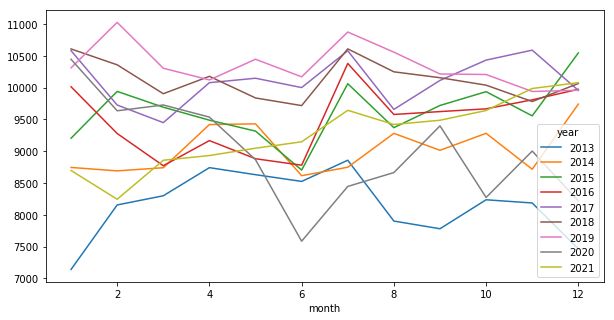

In [98]:
oecd_seasonal = seasonal_plot(get_flow())

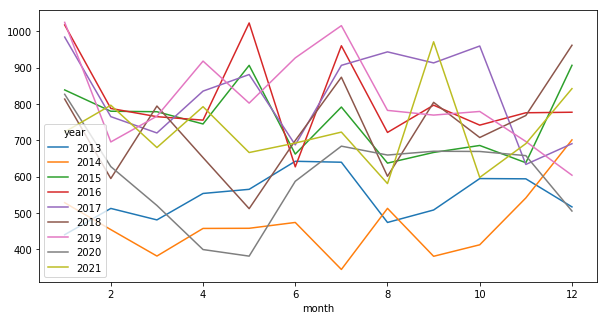

In [101]:
ceyhan = seasonal_plot(get_flow(origin='ceyhan'))

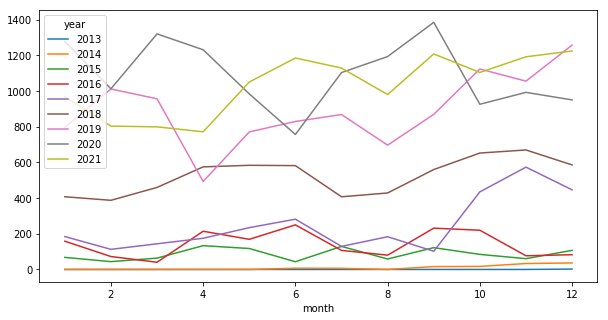

In [102]:
us = seasonal_plot(get_flow(origin='United States'))

In [105]:
waf = seasonal_plot(get_flow(origin='West Africa'))

In [112]:
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

In [128]:
dubai = tsa.get('price.platts.dubai_swap.m01.usd_bbl.daily')
brent = tsa.get('price.platts.ice_brent_swap.m01.usd_bbl.daily')

In [127]:
dubai

In [117]:
dubai_curve.tail(300).to_csv('dubai_check.csv')

In [133]:
spread_df = pd.merge(brent, dubai, left_index=True, right_index=True)
spread_df['spread'] = spread_df[spread_df.columns[0]]-spread_df[spread_df.columns[1]]

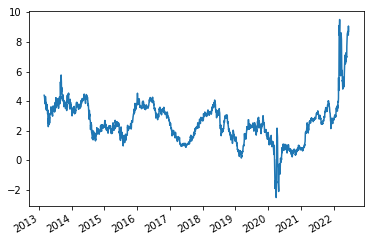

In [136]:
spread_df['spread'].plot()

In [137]:
spread_monthly = spread_df.resample('MS').mean()

In [139]:
spread_monthly['spread'].plot()

In [141]:
spread_monthly['spread']

2013-03-01    3.917500
2013-04-01    2.935714
2013-05-01    3.239524
2013-06-01    3.468000
2013-07-01    3.883636
                ...   
2022-02-01    3.932000
2022-03-01    7.664783
2022-04-01    5.402632
2022-05-01    7.013810
2022-06-01    8.633750
Freq: MS, Name: spread, Length: 112, dtype: float64

In [146]:
corr = pd.merge(get_flow(origin='United States'),spread_monthly['spread'], left_index=True, right_index=True)

In [147]:
corr

Total    spread
2013-03-01     0.00  3.917500
2013-04-01     0.00  2.935714
2013-05-01     0.00  3.239524
2013-06-01     0.00  3.468000
2013-07-01     0.00  3.883636
...             ...       ...
2022-02-01  1375.67  3.932000
2022-03-01  1253.15  7.664783
2022-04-01  1345.19  5.402632
2022-05-01  1485.50  7.013810
2022-06-01  1418.81  8.633750

[112 rows x 2 columns]

In [148]:
x = corr['Total']
y = corr['spread']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.223
Date:                Fri, 17 Jun 2022   Prob (F-statistic):              0.271
Time:                        10:04:38   Log-Likelihood:                -199.02
No. Observations:                 112   AIC:                             402.0
Df Residuals:                     110   BIC:                             407.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7546      0.199     13.831      0.000       2.360       3.149
Total         -0.0003      0.000     -1.106      0.271      -0.001       0.000
==============================================================================
Omnibus:                       40.259   Durbin-Watson:                   0.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.464
Skew:                           1.289   Prob(JB):                     8.46e-26
Kurtosis:                       7.254   Cond. No.                     1.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### north america imports forecast

In [7]:
import os
# DataGenic module
from pymarketdata.datagenic import DataGenic

# username = os.environ.get('DG_USERNAME')
# password = os.environ.get('DG_PASSWORD')
username = 'PIT018'
password = 'PIT018$1'

#prod
dg_url = "http://petro.datagenic.net:8080/"
dg = DataGenic(dg_url)
dg.connect(username, password)
print(f"DataGenic: {dg.version}")

DataGenic: Version 4.4.17.0.153, Built on 23-02-2022 05:43


In [13]:
na_imp = get_flow('North America')

In [61]:
def get_us_exp(prod=['Crude/Condensate'], origin='Northern America'):
    df = flows_client.get(
    with_intra_country=False,
    products=prod,
    from_zones=origin,
    flow_direction=[FlowsDirection.Export],
    split=[FlowsSplit.DestinationContinents],
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=date(2013,1,1),
#     end_date=today,
    )
    df.drop(columns=['Period End Date','Unknown', 'Oceania', 'Africa', 'Americas'], inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [81]:
us_exp = get_us_exp(origin='United States')

In [82]:
us_exp['total'] = us_exp.sum(axis=1)

In [85]:
us_exp['Asia'] = us_exp['Asia']/us_exp['total']
us_exp['Europe'] = us_exp['Europe']/us_exp['total']

In [45]:
brent_M2 = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M02'
brent_M2 = dg.get_time_series(brent_M2, datetime.date(2018,1,1), datetime.date.today())
brent_M2.rename(columns={'PRICE':'brent'}, inplace=True)
wti_m1 = dg.get_time_series('model://CMENYMCL_REL/US.NYMEX.CME.ELECTRONIC.FUT.CL.M01', datetime.date(2018,1,1), datetime.date.today())
wti_m1.rename(columns={'PRICE':'wti'}, inplace=True)

In [46]:
spread = pd.merge(brent_M2, wti_m1, left_index=True, right_index=True)
spread['spread'] = spread['brent'] - spread['wti']

<AxesSubplot:>

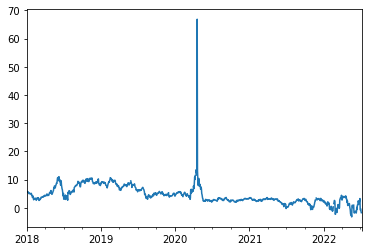

In [47]:
spread['spread'].plot()

In [48]:
spread_m = spread.resample('MS').mean()

<AxesSubplot:>

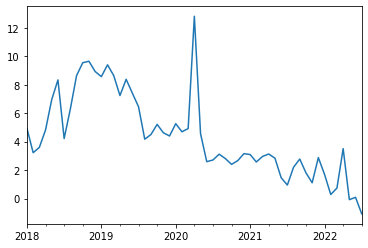

In [49]:
spread_m['spread'].plot()

In [50]:
corr = spread_m.merge(na_imp, left_index=True, right_index=True)

In [51]:
corr.to_csv('test.csv')

In [ ]:
# us production from TSA

In [8]:
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

In [9]:
us_prod = tsa.get('crude.rystad.united_states.production.kbd.monthly')

In [10]:
us_prod.head()

2010-01-01    5385.825
2010-02-01    5517.773
2010-03-01    5479.698
2010-04-01    5339.065
2010-05-01    5321.573
Name: crude.rystad.united_states.production.kbd.monthly, dtype: float64